In [5]:
!git clone https://github.com/AshishJangra27/datasets

fatal: destination path 'datasets' already exists and is not an empty directory.


In [6]:
import pandas as pd
data=pd.read_csv('/content/datasets/Job Postings/jobs.csv.zip')
data.head()
del data['posted_on']
del data['job_link']
del data['company_link']
data.dropna(subset=['company', 'job_id', 'resposibilities'], inplace=True)
data['experience']=data['experience'].fillna('5-10 years')#filling null with the most common values
data['location']=data['location'].fillna('Bangalore/Bengaluru')
#no. of missing rating and reviews is same means they are new companies
data['rating']=data['rating'].fillna('0.0')
data['reviews']=data['reviews'].fillna('0 Reviews')
data.isnull().sum()
data.drop_duplicates(subset='job_id').duplicated().sum()
data['job_id']=data['job_id'].astype('int64').astype(str)
data['min_experience']=data['experience'].str.replace('Yrs','').str.replace('years','').str.split('-').str[0].str.strip().astype('int')
data['max_experience']=data['experience'].str.replace('Yrs','').str.replace('years','').str.split('-').str[1].str.strip().astype('int')
data['clean_location']=data['location'].str.replace('(All Areas)','').str.replace(',','-').str.replace('/','~').str.strip().str.strip().str.split('~')

In [7]:
import re

def clean_and_convert_salary(salary_str):
    salary_str = str(salary_str).strip()
    if 'not disclosed' in salary_str.lower():
        return 0

    # Handle crore values
    if 'cr' in salary_str.lower():
        # Extract the number before 'Cr'
        crore_value = re.search(r'(\d+\.?\d*)', salary_str)
        if crore_value:
            return int(float(crore_value.group(1)) * 10000000)

    # Handle Lakhs and other formats
    numbers = re.findall(r'\d+\.?\d*', salary_str.replace(',', ''))
    numbers = [float(num) for num in numbers]

    if not numbers:
        return 0

    # If it's a range, return the average, otherwise the single value
    if len(numbers) > 1:
        return int((numbers[0] + numbers[1]) / 2 * 100000) # Assuming lakhs if not specified
    else:
        # Check if it's likely lakhs
        if numbers[0] < 100: # Heuristic for lakhs
             return int(numbers[0] * 100000)
        return int(numbers[0])



def get_min_max_salary(salary_str, get_max=False):
    salary_str = str(salary_str).strip()
    if 'not disclosed' in salary_str.lower():
        return 0

    # Handle crore values
    if 'cr' in salary_str.lower():
        # Extract the number before 'Cr'
        crore_value = re.search(r'(\d+\.?\d*)', salary_str)
        if crore_value:
            val = int(float(crore_value.group(1)) * 10000000)
            return val

    # Handle Lakhs and other formats
    numbers = re.findall(r'\d[\d,.]*', salary_str)

    if not numbers:
        return 0

    cleaned_numbers = [int(float(n.replace(',', ''))) for n in numbers]

    if 'lakh' in salary_str.lower() or (all(i<100 for i in cleaned_numbers) and len(cleaned_numbers)>0): # Heuristic for lakhs
      cleaned_numbers = [i * 100000 for i in cleaned_numbers]


    if get_max and len(cleaned_numbers)>1:
      return cleaned_numbers[1]

    return cleaned_numbers[0]


data['min_salary'] = data['salary'].apply(lambda x: get_min_max_salary(x))
data['max_salary'] = data['salary'].apply(lambda x: get_min_max_salary(x, get_max=True))

In [8]:
data.tail()

,job_id,job_role,company,experience,salary,location,rating,reviews,resposibilities,min_experience,max_experience,clean_location,min_salary,max_salary
79142,60123006615,.Net Fullstack Developer,Citiustech,3-8 Yrs,"7,00,000 - 17,00,000 PA.","Hybrid - Pune, Bangalore/Bengaluru, Mumbai (Al...",4.0,742 Reviews,"c#,.net core,javascript,Microservices,Angular,...",3,8,"[Hybrid - Pune- Bangalore, Bengaluru- Mumbai]",700000,1700000
79143,11222009693,Senior (BI) Business Intelligence Architect,Hexaware Technologies,10-13 Yrs,Not disclosed,"Hybrid - Pune, Chennai, Bangalore/Bengaluru, M...",3.7,3172 Reviews,"Informatica Mdm,etl,business intelligence,Agil...",10,13,"[Hybrid - Pune- Chennai- Bangalore, Bengaluru-...",0,0
79144,151222006599,PowerBI Developer,EY,5-10 Yrs,Not disclosed,"Hybrid - Pune, Mumbai (All Areas)",3.8,6267 Reviews,"pagination,Power Bi,Dax",5,10,[Hybrid - Pune- Mumbai],0,0
79145,271222005611,Customer Service Associate,Tech Mahindra,0-2 Yrs,"2,50,000 - 3,50,000 PA.","Temp. WFH - Noida, Kolkata, New Delhi, Hyderab...",3.7,21440 Reviews,"Bengali,International BPO,BPO,Customer Service...",0,2,[Temp. WFH - Noida- Kolkata- New Delhi- Hydera...,250000,350000
79146,211222006941,Senior Java BED ( PAN India)- KG,Tech Mahindra,8-12 Yrs,"25,00,000 - 27,50,000 PA.","Temp. WFH - Noida, Kolkata, Hyderabad/Secunder...",3.7,21440 Reviews,"Kafka,sql,spring boot,REST API,java,Lambda,Des...",8,12,"[Temp. WFH - Noida- Kolkata- Hyderabad, Secund...",2500000,2750000


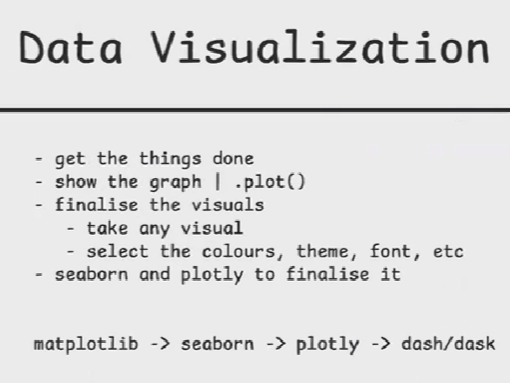

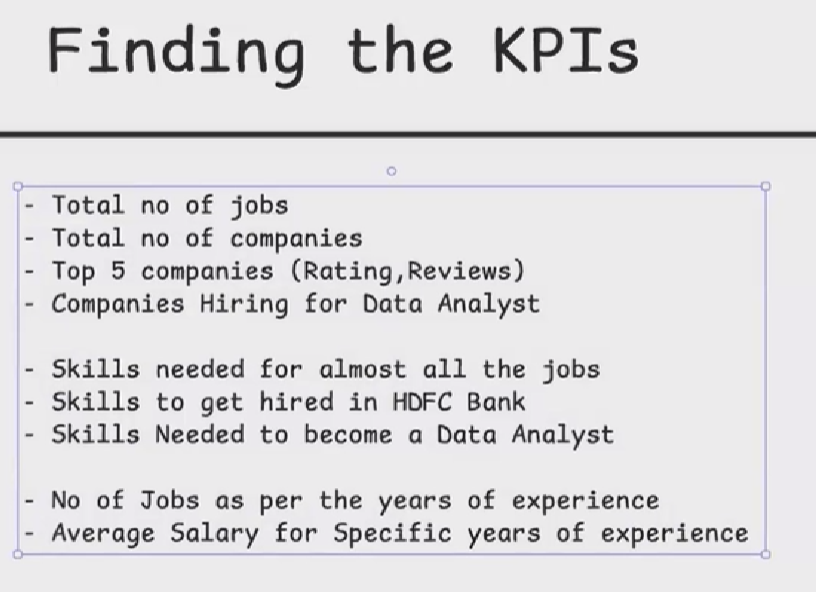

In [10]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
data['company'].nunique()#no of unique comapny

15313

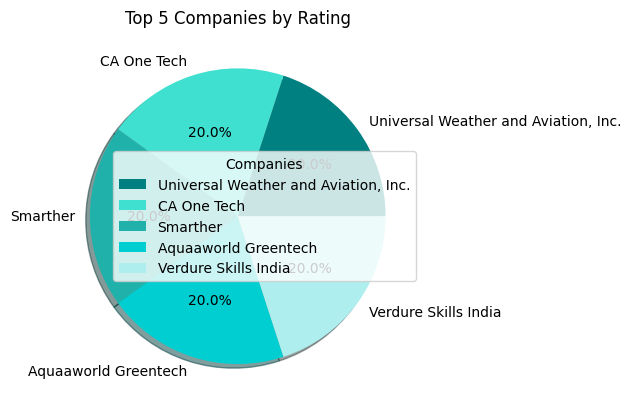

In [52]:
import matplotlib.pyplot as plt

# Get the top 5 companies by rating
top_5_by_rating = data.sort_values(by='rating', ascending=False).head()

# Define the colors
colors = ['#008080', '#40E0D0', '#20B2AA', '#00CED1', '#AFEEEE']

# Create a pie chart
plt.pie(top_5_by_rating['rating'], labels=top_5_by_rating['company'], autopct='%1.1f%%', colors=colors, shadow=True)
plt.title('Top 5 Companies by Rating')
plt.legend(title='Companies', bbox_to_anchor=(1, 0.5), loc="center right")
plt.show()

<Axes: ylabel='reviews'>

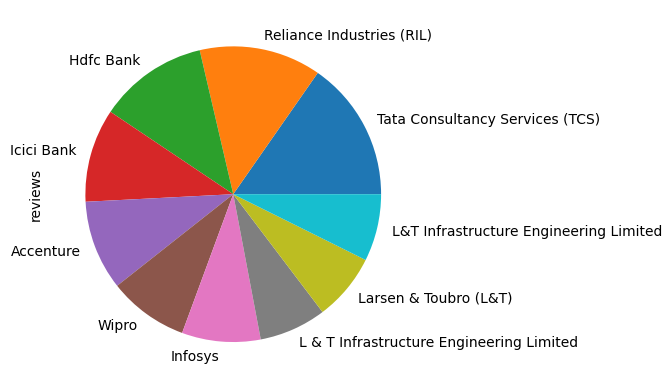

In [48]:
# top 10 companies based on reviews
data.groupby('company')['reviews'].max().sort_values(ascending=False).head(10).plot(kind='pie')

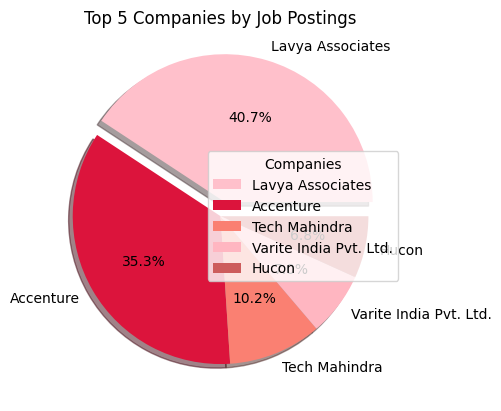

In [51]:
import matplotlib.pyplot as plt

# Get the value counts of the top 5 companies
top_5_companies = data['company'].value_counts().head()

# Define the colors
colors = ['#FFC0CB', '#DC143C', '#FA8072', '#FFB6C1', '#CD5C5C']

# Explode the first slice (the largest one)
explode = (0.1, 0, 0, 0, 0)

# Create a pie chart
plt.pie(top_5_companies, labels=top_5_companies.index, autopct='%1.1f%%', colors=colors, shadow=True, explode=explode)
plt.title('Top 5 Companies by Job Postings')
plt.legend(title='Companies', bbox_to_anchor=(1, 0.5), loc="center right")
plt.show()

**reviews matter more than rating**

In [32]:
len(data[data['job_role']=='Data Analyst'])# no of jobs offering data analyst

61

In [37]:
data['resposibilities'].str.lower().str.split(',').explode().value_counts().head()# explode is adding skills into one giant list

,count
resposibilities,
sales,6159
communication,4010
customer service,3803
agency,3457
tied,3313


In [56]:
import plotly.express as px

# Get the data for top skills for HDFC Bank
top_skills_hdfc = data[data['company']=='Hdfc Bank']['resposibilities'].str.lower().str.split(',').explode().value_counts().head()

# Create an interactive pie chart with Plotly
fig = px.pie(
    values=top_skills_hdfc.values,
    names=top_skills_hdfc.index,
    title='Top 5 Skills for HDFC Bank',
    color_discrete_sequence=px.colors.sequential.Blues_r
)

# Improve label readability
fig.update_traces(textposition='inside', textinfo='percent+label', pull=[0.05, 0, 0, 0, 0])
fig.update_layout(showlegend=False)
fig.show()

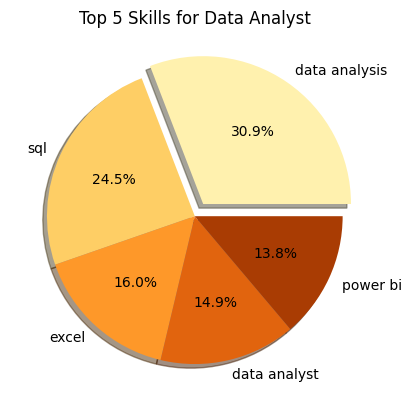

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the data for top skills for Data Analyst
top_skills_da = data[data['job_role']=='Data Analyst']['resposibilities'].str.lower().str.split(',').explode().value_counts().head()

# Define the colors using a seaborn palette
colors = sns.color_palette('YlOrBr', 5)

# Explode the first slice
explode = (0.1, 0, 0, 0, 0)

# Create a pie chart
plt.pie(top_skills_da, labels=top_skills_da.index, autopct='%1.1f%%', colors=colors, shadow=True, explode=explode)
plt.title('Top 5 Skills for Data Analyst')
plt.show()